# 3.1. Embeddings Experiment

According to [multiple estimates](https://mitsloan.mit.edu/ideas-made-to-matter/tapping-power-unstructured-data), 80% of data generated by businesses today is unstructured data such as text, images, or audio. This data has enormous potential for machine learning applications, but there is _some_ work to be done before it can be used directly.

Embeddings are the backbone of our system. Our goal is to understand how different embeddings or ways of using embeddings impact relevancy of the returned results for a given query.

📝**Hypothesis**

The hypothesis for this experiment is an exploratory one: "Can introducing a new word embedding method improve the system's performance?"

🎯 **Measure of Success**

As we highlighted in the `Chapter 3. Experiments`, our system has two components: the retrieval and the generative one. Take a moment to think what would be the part that would be impacted if we change the embedding model?

<details markdown="1">
<summary> Hint:</summary>

Well, embeddings are used for transforming the input query from plain text into a vector, as well as for vectorizing the documents we have in our index. Therefore, it contributes to how well the system can retrieve relevant documents based on the input query and the documents. In other words, the retrieval component.

</details>

<!-- <details markdown="1">
<summary> Here’s how to connect to your AKS cluster:</summary>

```sh
AKS_NAME=$(az aks list -g "$ENV_RESOURCE_GROUP_NAME" --query "[0].name" -o tsv)
az aks get-credentials \
--resource-group "$ENV_RESOURCE_GROUP_NAME" \
--name "$AKS_NAME"
```

</details> -->


## 👀 Get to know the data

Before we try out different embedding models, let's first try to understand the data. In what follows, you will see the data being clustered and keywords extracted from each cluster. To accomplish this, we performed Dimensionality Reduction, using [t-SNE](https://towardsdatascience.com/what-why-and-how-of-t-sne-1f78d13e224d). If you want to see the code we've been using to accomplish this, go to [t-SNE.ipynb](./helpers/t-SNE.ipynb).

Note: in this experiment, we work with the 200 documents from the Solution Ops Playbook, which were previously chunked in size of 300. The dataset can be found at [chunks-solution-ops-200-300-0.json](./output/chunks-solution-ops-200-300-0.json)


Determine the optimal number of clusters
The optimum cluster number is 5 



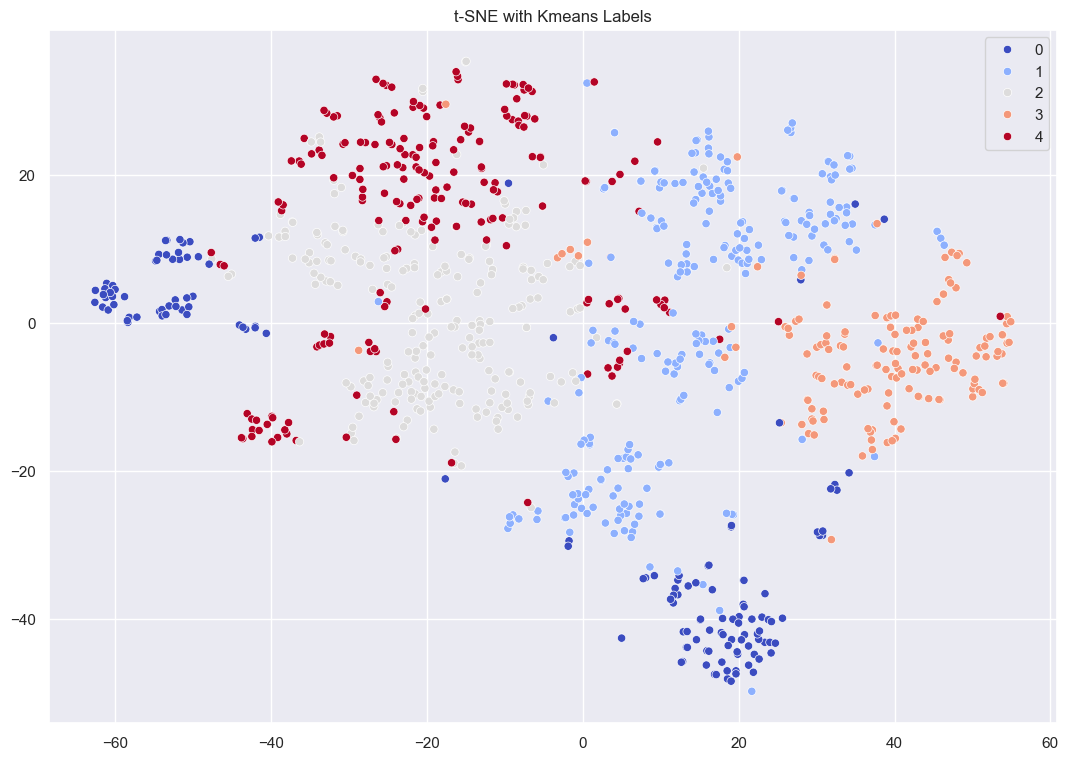

Generate words per cluster...
Cluster 1's Keywords:


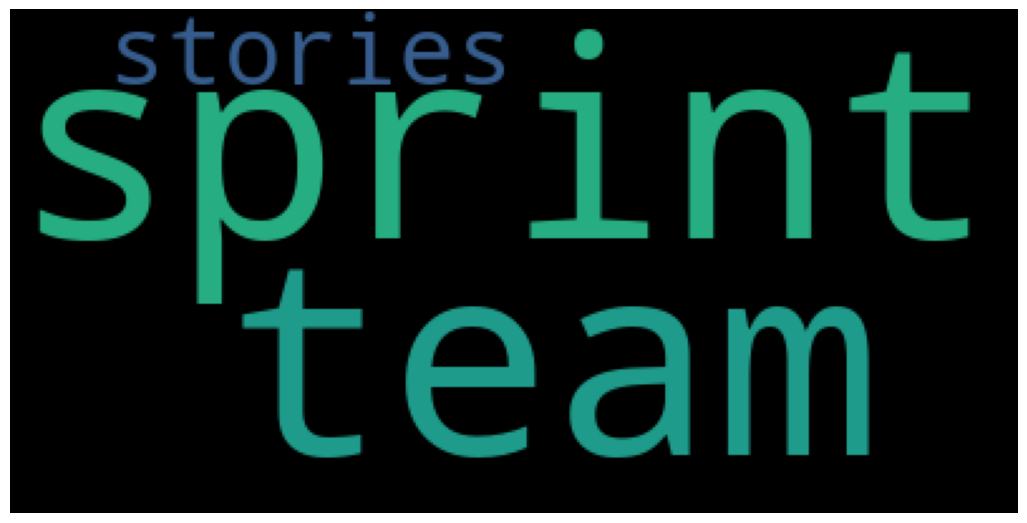

Cluster 2's Keywords:


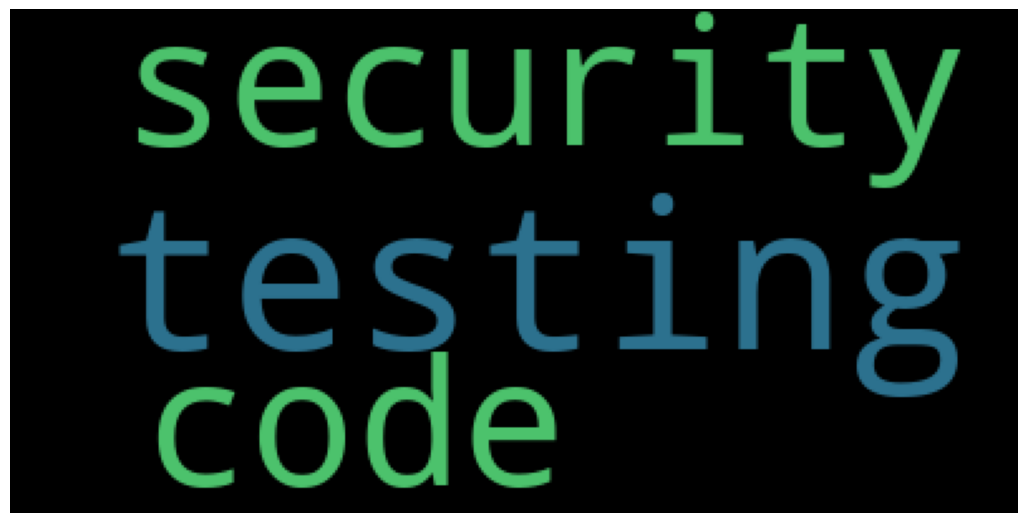

Cluster 3's Keywords:


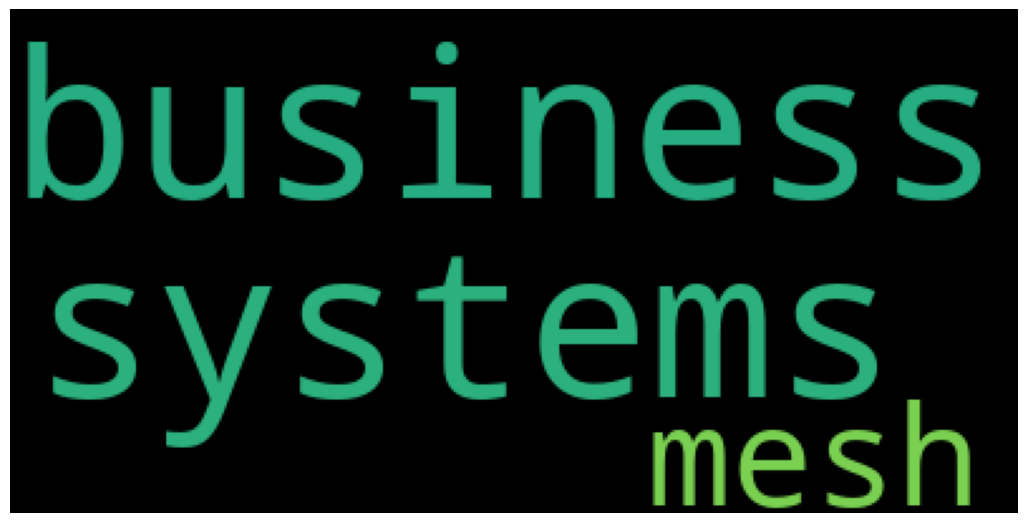

Cluster 4's Keywords:


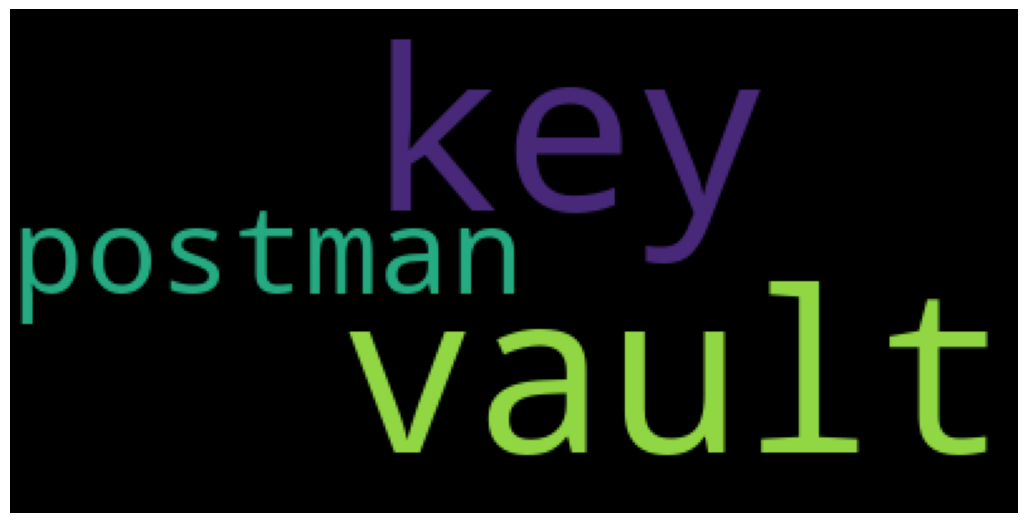

Cluster 5's Keywords:


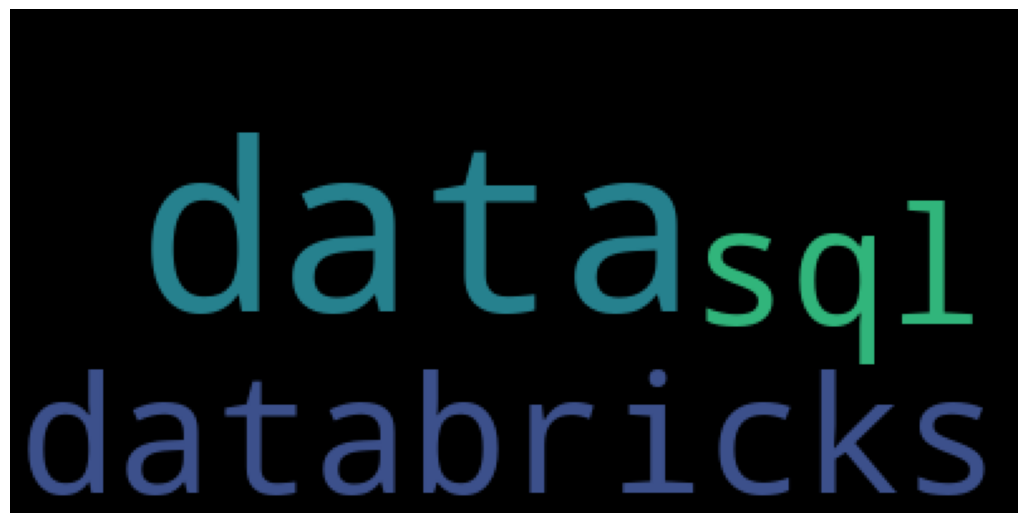

<Figure size 1300x900 with 0 Axes>

In [1]:
%run -i ./helpers/t-SNE.ipynb

```{note}

```

As we have seen from the cluster from above, the data `can` be clustered, and the clusters seem to be different from one another. One is centered on data (sql, databricks) vs backlog related (stories, sprint, team) vs engineering fundamentals (security, testing, code). However, if we think about these clusters on a broader sense, they are part of one big cluster, which is IT.

## Which Embeddings Model to use?

Glad you asked! There are several embedding options:

1. [OpenAI models](https://openai.com/blog/new-embedding-models-and-api-updates?ref=haihai.ai), such as: [`text-embedding-ada-002`](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings), `text-embedding-3-small`, `text-embedding-3-large`
2. Open source models, which you can find at [HuggingFace](https://huggingface.co/models). The [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard) ranks the performance of embeddings models on a few axis, though not all models can be run locally.

In this experiment, we will compare `text-embedding-ada-002` (from OpenAI) and `infloat/e5-small-v2` (open-source).

### 1. Use `text-embedding-ada-002` from OpenAI

This model has a maximum token limit of [8191](https://platform.openai.com/docs/guides/embeddings/embedding-models). Usage is priced per input token, it is available either as Pay-As-You-Go or as Provisioned Throughput Units (PTUs) model. More price related info can be found [here](https://azure.microsoft.com/en-us/pricing/details/cognitive-services/openai-service/).

1.1 Embed an input query


In [6]:
# import os
# import dotenv

# %reload_ext dotenv
# %dotenv

# azure_aoai_endpoint = os.environ["azure_aoai_endpoint"]
# azure_openai_key = os.environ["azure_openai_key"]
# azure_openai_embedding_deployment = os.environ["AZURE_OPENAI_EMBEDDING_DEPLOYMENT"]

%run -i ./pre-requisites.ipynb

In [7]:
import requests


def get_query_embedding(
    query,
    endpoint=azure_aoai_endpoint,
    api_key=azure_openai_key,
    api_version="2023-07-01-preview",
    embedding_model_deployment=azure_openai_embedding_deployment,
):
    request_url = f"{endpoint}/openai/deployments/{embedding_model_deployment}/embeddings?api-version={api_version}"
    headers = {"Content-Type": "application/json", "api-key": api_key}
    request_payload = {"input": query}
    embedding_response = requests.post(
        request_url, json=request_payload, headers=headers, timeout=None
    )
    if embedding_response.status_code == 200:
        data_values = embedding_response.json()["data"]
        embeddings_vectors = [data_value["embedding"] for data_value in data_values]
        return embeddings_vectors
    else:
        raise Exception(f"failed to get embedding: {embedding_response.json()}")

In [8]:
query = "Hello"

query_vectors = get_query_embedding(
    query,
    azure_aoai_endpoint,
    azure_openai_key,
    "2023-07-01-preview",
    azure_openai_embedding_deployment,
)

print(f"The embedded vector is: {query_vectors[0]}")
print(f"The length of the embedding is: {len(query_vectors[0])}")

The embedded vector is: [-0.021819873, -0.0072516315, -0.02838273, -0.02452299, -0.023587296, 0.028824585, -0.012300482, -0.002914298, -0.008369266, -0.0053834915, 0.029370407, -0.0032050782, -0.015555919, -0.0026917458, 0.012313478, -0.0009478779, 0.038779333, 0.0057538706, 0.018687896, -0.0139704365, -0.019740552, 0.009954749, 0.0052600317, 0.009025552, -0.0081548365, -0.0052242936, 0.0024545733, -0.012345967, 0.003312293, -0.015659885, 0.0036940433, -0.016166719, -0.017882159, -0.012904785, 0.0040774182, -0.016218703, -0.0010892067, -0.00985728, 0.021300042, -0.008564203, 0.013080227, -0.0062801987, 0.00324569, -0.0067642904, -0.02804484, 0.013216683, -0.012378457, 0.00046459824, -0.014815161, 0.03599824, 0.009187999, 0.0127943205, -0.014750182, -0.0007468498, -0.0061697345, -0.01472419, -0.0077584656, 0.0062542073, 0.007641504, -0.043587763, 0.002810332, 0.024042146, -0.0059455577, 0.015023093, -0.0044477973, 0.020221395, 0.015101068, 0.0052957702, 0.008122347, 0.017739207, 0.02276

### 1.2. Embed the chunks and save to a file


In [9]:
import json


def generate_embeddings_for_chunks(path_to_input_file, path_to_output_file):
    if os.path.exists(path_to_output_file):
        print(
            f"Embeddings were already created for chunked data {path_to_input_file} at: {path_to_input_file} "
        )
        return
    try:
        with open(path_to_input_file, "r", encoding="utf-8") as file:
            input_data = json.load(file)
            for chunk in input_data:
                content = chunk["chunkContent"]
                content_emebddings = get_query_embedding(content)[0]
                chunk["chunkContentVector"] = content_emebddings

        with open(path_to_output_file, "w") as f:
            json.dump(input_data, f)
    except Exception as e:
        print(f"Failed to generate embeddings for chunks: {e}")

In [10]:
totalNumberOfDocuments = 200
path_to_file = f"./output/chunks-solution-ops-{totalNumberOfDocuments}.json"
path_to_output_file = f"./output/chunks-solution-ops-{totalNumberOfDocuments}.json"
generate_embeddings_for_chunks(path_to_file, path_to_output_file)

Embeddings were already created for chunked data ./output/chunks-solution-ops-200.json at: ./output/chunks-solution-ops-200.json 


### 2. Use e5-small-v2 from Hugging Face

We will use [`infloat/e5-small-v2`](https://huggingface.co/intfloat/e5-small-v2) from Hugging Face. This model is open source, size 0.13 GB. The model is limited to working with English texts and can handle texts with a maximum of 512 tokens. Being open sourced, it means there is no price associated with it.

### 2.1. Embed an input query using the `e5-small-v2 model`

Look at the [</> Use in sentence-transformers](https://huggingface.co/intfloat/e5-small-v2) section from Hugging Face.

<details markdown="1">
<summary> 🔍 Solution:</summary>

```python
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("intfloat/e5-small-v2")
input = "Hello"

embedded_input = model.encode(query, normalize_embeddings=True)
print(embedded_input)
```

</details>

### 2.1. Embed the chunks and save to a file

Create a function, similar to `generate_embeddings_for_chunks`, to embed the data and to save it to a file.

<details markdown="1">
<summary> 🔍 Solution:</summary>

```python
%pip install sentence_transformers

import json
from sentence_transformers import SentenceTransformer
import os


def embed_chunk(chunk, model):
    # print(type(embedded_input))
    embedded_input = model.encode(
        chunk, normalize_embeddings=True
    )  # Note that the type is a ndarray.
    return (
        embedded_input.tolist()
    )  # We need to reshape the array to be a list of floats


def generate_embeddings_with_intfloat_e5_small_v2(
    path_to_input_file, path_to_output_file
):
    if os.path.exists(path_to_output_file):
        print(
            f"Embeddings were already created for chunked data {path_to_input_file} at: {path_to_input_file} "
        )
        return
    try:
        model = SentenceTransformer("intfloat/e5-small-v2")
        with open(path_to_input_file, "r", encoding="utf-8") as file:
            input_data = json.load(file)
            for chunk in input_data:
                content = chunk["chunkContent"]
                content_emebddings = embed_chunk(content, model)
                chunk["chunkContentVector"] = content_emebddings

        with open(path_to_output_file, "w") as f:
            json.dump(input_data, f)
    except Exception as e:
        print(f"Failed to generate embeddings for chunks: {e}")


totalNumberOfDocuments = 200
path_to_file = f"./output/chunks-solution-ops-{totalNumberOfDocuments}.json"
path_to_output_file = (
    f"./output/chunks-solution-ops-small-model-{totalNumberOfDocuments}.json"
)
generate_embeddings_with_intfloat_e5_small_v2(path_to_file, path_to_output_file)
```

</details>


## 📈 Evaluation

## 💡 Conclusions
